#### 네이버 증권 엔화 환율 & 니케이 지수 crawling

In [ ]:
import requests

#### 1. 엔화 환율 crawling

In [268]:
marketIndexCd, pageSize, page = "FX_JPYKRW", 60, 1

url = "https://m.stock.naver.com/api/json/marketindex\
/marketIndexDay.nhn?marketIndexCd={}&pageSize={}&page={}".format(marketIndexCd, pageSize, page)
params = {
"cookie" : "NNB=CHONSQLXFY7V6; NRTK=ag#all_gr#1_ma#-2_si#0_en#0_sp#0; NDARK=N; ASID=70a97656000001746b61be7b00000065; nx_ssl=2; nid_inf=994256327; NID_AUT=QVz8pSCLtSUPDo1ng3dRTCdyrxhbWi+iOWenNiVAl++qfjsfzBtkCe/Fxkar3tO6; NID_JKL=N7S+Y7jX+bN4l9+LdM5syPyRSjU0h4W6jzj2iWVmWIo=; NaverSuggestUse=use%26unuse; _fbp=fb.1.1602051895913.121485294; _ga_4BKHBFKFK0=GS1.1.1602051892.1.1.1602051909.43; naver_mobile_stock_codeList=352820%7C; _ga=GA1.2.885590883.1602051893; _gid=GA1.2.1096538477.1603272054; NID_SES=AAABkj5yUgGxeBb/W5S8FkrpJIiEsii1jo1mekr6faYGjbo0Kq5NW48T0NmpQKv4Rj6MbIUUBAap4aO5+6eKCe9azkjS9BCQ6RmpNCCnjb/xa837w0jkaHDp4zzuiO6luI3J4XbFww+cAxAx8WP6xfkedKVk72yHMiM1TyVxcojGOnY2/HTVYEx1vjzuopIpm9K8MKBnBZ35ZfaFafLEXT2GTjrjhbxIaThcLZZxpNJJ7PrCSlg6PcKyQfD0YU9bmOLaXelOC7rfUdjF+rJ1qf2HsnjAwpi1YpUE3Mb4RM93+9s4Z98xgT+c/Lq1yImx3VxP2/IBixuEVI+5IHjt/rpi3CI6ZggNOGBCfKr+GrDlcDRTa8Wxh6th4QiYj4UlJIDIBhgKbJPnpS6iPrLTS0UlWpNscsn+Wc96K+Oitae9c8xpue5JrZKJ7pivuLzhI6rexVJCElOqD/Lvwz4KDGGY4OCGHwguZ0r+tz40VvUyvSsWi1OYaXtmGa8Nca8oJ3TnZ7bVoa6iLhLx93T6jgXCfhFnpnFJaFhCIA0qR7BzCgKp; MM_NEW=1; NFS=2; MM_NOW_COACH=1; JSESSIONID=72A12E415811D858090272EEF32701AE; BMR=; XSRF-TOKEN=7f26bb78-57b5-4e6f-92aa-54d0ed2afdec"
}

In [269]:
response = requests.get(url, headers=params)
response

<Response [200]>

In [270]:
response.text[:200]

'{"result":{"marketIndexDay":[{"dt":"20201021","nv":1080.91,"cv":2.26,"cr":0.21,"cbv":1099.82,"csv":1062.0,"sv":1091.5,"rv":1070.32},{"dt":"20201020","nv":1078.65,"cv":-3.15,"cr":-0.29,"cbv":1097.52,"c'

In [271]:
datas = response.json()["result"]["marketIndexDay"]
jpy_df = pd.DataFrame(datas)
jpy_df.tail()

,dt,nv,cv,cr,cbv,csv,sv,rv
55,20200729,1137.09,-3.17,-0.28,1156.98,1117.20,1148.23,1125.95
56,20200728,1140.26,3.45,0.30,1160.21,1120.31,1151.43,1129.09
57,20200727,1136.81,5.39,0.48,1156.70,1116.92,1147.95,1125.67
58,20200724,1131.42,13.00,1.16,1151.21,1111.63,1142.50,1120.34
59,20200723,1118.42,-0.74,-0.07,1137.99,1098.85,1129.38,1107.46


In [272]:
jpy_df["dt"] = pd.to_datetime(jpy_df["dt"]).dt.date
jpy_df["dt"].tail(2)

58    2020-07-24
59    2020-07-23
Name: dt, dtype: object

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(jpy_df[::-1]["dt"], jpy_df[::-1]["nv"], "r*:", label = "jpy")
plt.legend(loc=0)

step = len(jpy_df) // 10
plt.xticks(jpy_df[::step]["dt"])

plt.show()

#### 2. 니케이 지수 crawling

In [253]:
page_2, pageSize_2 = 1, 60

url_2 = "https://api.stock.naver.com/index/.N225/price?page={}&pageSize={}".format(page_2, pageSize_2)

In [254]:
response_2 = requests.get(url_2)
response_2

<Response [200]>

In [255]:
response_2.text[:500]

'[{"stockExchangeType":{"code":"TYO","zoneId":"Asia/Tokyo","nationType":"JPN","delayTime":20,"startTime":"0900","endTime":"1500","closePriceSendTime":"1901","nameKor":"도쿄 거래소","nameEng":"Tokyo Stock Exchange","name":"TOKYO"},"localTradedAt":"2020-10-21T15:15:02+09:00","worldIndexSymbol":".N225","openPrice":"23,615.52","highPrice":"23,702.30","lowPrice":"23,611.33","closePrice":"23,639.46","compareToPreviousClosePrice":"72.42","fluctuationsRatio":"0.31","compareToPreviousPrice":{"code":"2","text":'

In [256]:
datas_2 = response_2.json()
nikkei_df = pd.DataFrame(datas_2)
nikkei_df.tail(2)

,stockExchangeType,localTradedAt,worldIndexSymbol,openPrice,highPrice,lowPrice,closePrice,compareToPreviousClosePrice,fluctuationsRatio,compareToPreviousPrice
58,"{'code': 'TYO', 'zoneId': 'Asia/Tokyo', 'natio...",2020-07-28T15:15:03+09:00,.N225,"22,735.02","22,842.19","22,646.22","22,657.38",-58.47,-0.26,"{'code': '5', 'text': '하락', 'name': 'FALLING'}"
59,"{'code': 'TYO', 'zoneId': 'Asia/Tokyo', 'natio...",2020-07-27T15:15:03+09:00,.N225,"22,495.95","22,741.13","22,429.57","22,715.85",-35.76,-0.16,"{'code': '5', 'text': '하락', 'name': 'FALLING'}"


In [257]:
nikkei_df['dt'] = pd.to_datetime(nikkei_df['localTradedAt']).dt.date
nikkei_df.tail(2)

,stockExchangeType,localTradedAt,worldIndexSymbol,openPrice,highPrice,lowPrice,closePrice,compareToPreviousClosePrice,fluctuationsRatio,compareToPreviousPrice,dt
58,"{'code': 'TYO', 'zoneId': 'Asia/Tokyo', 'natio...",2020-07-28T15:15:03+09:00,.N225,"22,735.02","22,842.19","22,646.22","22,657.38",-58.47,-0.26,"{'code': '5', 'text': '하락', 'name': 'FALLING'}",2020-07-28
59,"{'code': 'TYO', 'zoneId': 'Asia/Tokyo', 'natio...",2020-07-27T15:15:03+09:00,.N225,"22,495.95","22,741.13","22,429.57","22,715.85",-35.76,-0.16,"{'code': '5', 'text': '하락', 'name': 'FALLING'}",2020-07-27


In [ ]:
nikkei_df['closePrice'] = nikkei_df['closePrice'].str.replace(",","").astype('float')

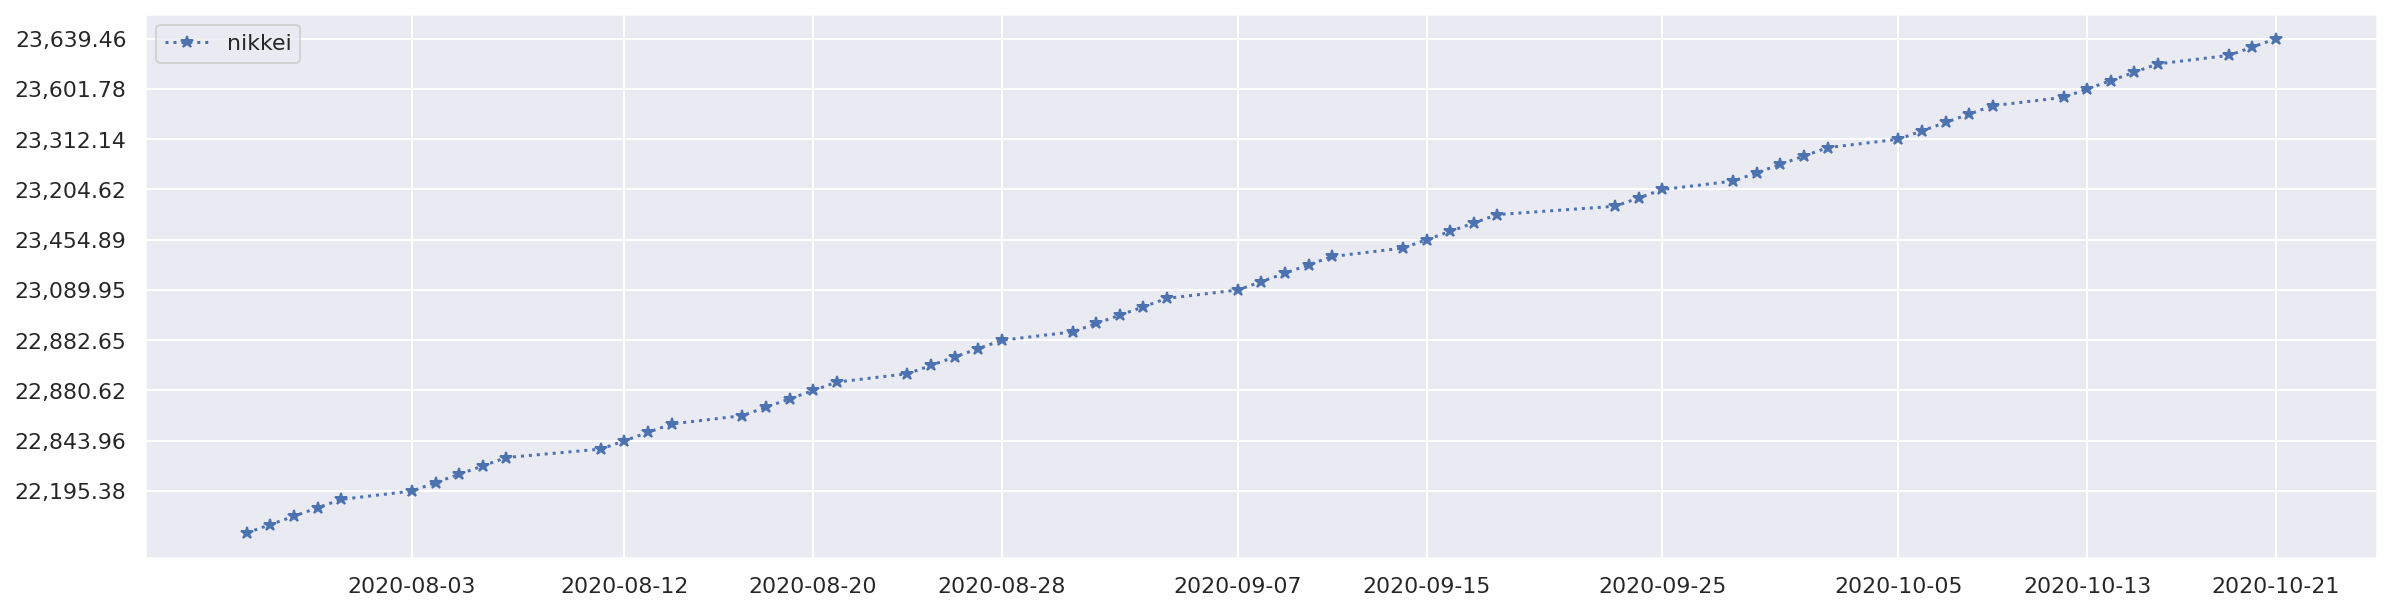

In [258]:
plt.figure(figsize=(20, 5))
plt.plot(nikkei_df[::-1]["dt"], nikkei_df[::-1]["closePrice"], "b*:", label = "nikkei")
plt.legend(loc=0)

step = len(nikkei_df) // 10
plt.xticks(nikkei_df[::step]["dt"])
plt.yticks(nikkei_df[::step]["closePrice"])

plt.show()

#### 3. 정규화

In [259]:
from sklearn import preprocessing

In [261]:
preprocessing.minmax_scale(nikkei_df[::-1]["closePrice"])

array([0.51289308, 0.48307863, 0.35036433, 0.32085073, 0.        ,
       0.24750017, 0.44038896, 0.41040115, 0.36109284, 0.31611367,
       0.53042889, 0.57821766, 0.78506269, 0.80533162, 0.70711784,
       0.68383024, 0.71418519, 0.59691096, 0.6171442 , 0.65039544,
       0.80911005, 0.80609649, 0.76428386, 0.59794608, 0.72904907,
       0.72818732, 0.78380831, 0.89516248, 0.76253487, 0.70365045,
       0.79756569, 0.67437651, 0.77785256, 0.86505739, 0.94297675,
       0.88973704, 0.90026158, 0.82063402, 0.84150464, 0.83446278,
       0.70256434, 0.76212184, 0.91866424, 0.93267657, 0.75217859,
       0.75208171, 0.67303034, 0.81694737, 0.87894734, 0.87338422,
       0.98773156, 0.97377022, 0.94266571, 0.96463773, 0.97735999,
       0.91642573, 0.86716842, 1.        , 0.94692346, 0.98385115])

In [262]:
preprocessing.minmax_scale(jpy_df[::-1]["nv"])

array([0.64551209, 0.8565168 , 0.9440026 , 1.        , 0.94854731,
       0.96542769, 0.95228047, 0.77974355, 0.77179029, 0.72374615,
       0.72423308, 0.70394416, 0.65265379, 0.60509658, 0.48807012,
       0.48969323, 0.56062328, 0.70102256, 0.65622464, 0.69453011,
       0.7589677 , 0.73153709, 0.58708002, 0.62019153, 0.63853271,
       0.71774063, 0.68268138, 0.65947087, 0.63479955, 0.63788346,
       0.67813667, 0.64323973, 0.65167992, 0.65086837, 0.65021912,
       0.63723422, 0.60850511, 0.62327544, 0.60574582, 0.67586431,
       0.58902776, 0.63609804, 0.51907158, 0.46761889, 0.53627658,
       0.58415842, 0.52426554, 0.46112644, 0.32202565, 0.3356598 ,
       0.22252881, 0.13569226, 0.18422334, 0.13098523, 0.14283396,
       0.19104042, 0.15938971, 0.05112806, 0.        , 0.02645674])

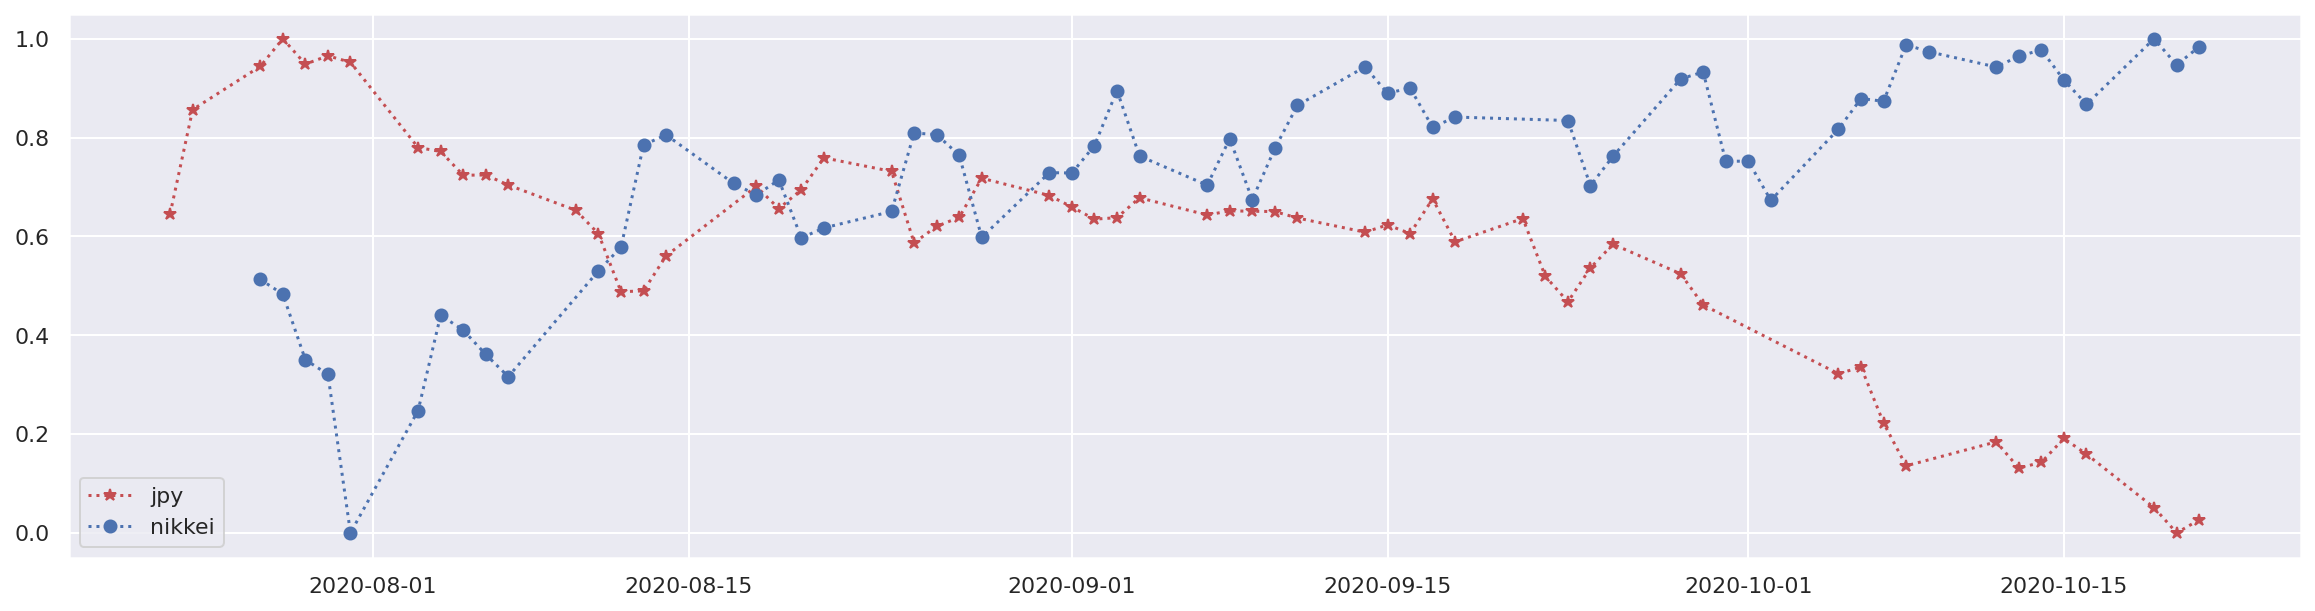

In [266]:
plt.figure(figsize=(20, 5))

plt.plot(jpy_df[::-1]["dt"], 
         preprocessing.minmax_scale(jpy_df[::-1]["nv"]), 
         "r*:", label="jpy")
plt.plot(nikkei_df[::-1]["dt"], 
         preprocessing.minmax_scale(nikkei_df[::-1]["closePrice"]), 
         "bo:", label="nikkei")

plt.legend(loc=0)

plt.show()

In [263]:
np.corrcoef(jpy_df["nv"], nikkei_df["closePrice"])[0, 1]

-0.7498714433095011